## Example: The three-element Windkessel model
#### Section 4.3 of the paper

For more information about the Windkessel model, see 

1: Shi et.al, *Review of zero-D and 1-D models of blood flow in the cardiovascular system. Biomedical engineering online*, 2011.

2: Harrod et.al, *Predictive modeling of secondary pulmonary hypertension in left ventricular diastolic dysfunction*, 2021.

3: Yu et.al, *Variational inference with NoFAS: Normalizing flow with adaptive surrogate for computationally expensive models*, 2022.

In [1]:
# Note: Please initiate Jupyter Lab where this script is located
# Note: re-start the python kernel if some attribute of a class is not identified
# Note: there is an abuse of notation of x (X) and v. The x (X) in the code mostly means the v in the paper
# Note: the hyperparameters have been adjusted for faster execution within JupyterLab. 
#        For more precise results and improved efficiency, we recommend running the code locally with appropriately fine-tuned hyperparameters

import torch
import os
import math
import numpy as np
import sys
import time
import copy
from matplotlib import pyplot as plt
from PIL import Image
from pdf2image import convert_from_path
from Tools.Data_generation import * # Data generation
from Tools.DNN_tools import *       # Common tools in DNN modeling
from Tools.Training_tools import *  # Main trainer class of the inVAErt network and the training/testing algorithm
from Tools.plotter import *         # Common plotting tools 

matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

The three-element Windkessel model, also known as the RCR model, is formulated through the following coupled algebraic and ordinary differential system of equations:

$$
Q_p = \displaystyle{\frac{P_p-P_{sys}}{R_p}}, \\
Q_d = \displaystyle{\frac{P_{sys}-P_d}{R_d}}, \\
\dot{P}_{sys} = \displaystyle{\frac{Q_p-Q_d}{C}}, P_p(0) = 0 \ .
$$

* $C$: overall systemic capacitance
* $R_p$: proximal resistance
* $R_d$: distal resistence
* $Q_d$: distal flow rate
* $Q_p$: proximal flow rate (given)
* $P_p, P_d, P_{sys}$: aortic pressure, distal pressure, systemic pressure

Rearranging with respect to the variable of interest, $P_p(t)$, the aortic pressure, we have the following first-order, linear ODE:

$$
\dot{P}_p = R_p \dot{Q}_p + \displaystyle{\frac{Q_p}{C}} - \displaystyle{\frac{P_p-Q_pR_p-P_d}{CR_d}}, \\
P_p(0) = 0.
$$

The proximal flow rate $Q_p$ usually comes from medical measurement, is given for the current problem. We plot its profile as well as a diagram of the RCR model below:

Text(0.5, 1.0, 'Schematic representation of an RCR circuit model')

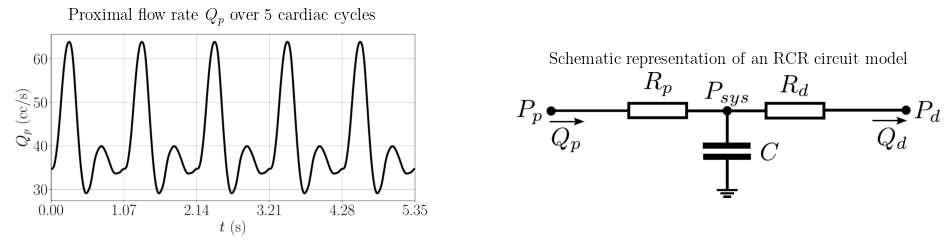

In [2]:
# show figures
plt.figure(figsize=(12, 10))

# plot data profile of the given proximal flow rate Q_p
plt.subplot(1, 2, 1)
im_flow = convert_from_path('Diagrams/QpFiveCycles.pdf')
plt.imshow(im_flow[0])
plt.axis('off')
plt.title('Proximal flow rate $Q_p$ over 5 cardiac cycles', fontsize=fs)

# plot the diagram of the circuit RCR model
plt.subplot(1, 2, 2)
im_rcr = convert_from_path('Diagrams/RCR-diag.pdf')
plt.imshow(im_rcr[0])
plt.axis('off')
plt.title('Schematic representation of an RCR circuit model', fontsize=fs)

We will also study a parametric family of the RCR system, the parameters are listed in the following table.

| | |
|-----|:-----|
|Cardiac cycle ($t_c$) | 1.07 (s)  |
|Distal pressure ($P_d$)| 55 (mmHg)|
|Proximal resistance ($R_p$)| [500, 1500] (Barye$\cdot$s/ml)|
|Distal resistance ($R_d$)| [500, 1500] (Barye$\cdot$s/ml)|
|Capacitance ($C$)| [$1\times 10^{-5}, 1\times 10^{-4}$] (ml/Barye)|

We are considering the following map:

$$
\boldsymbol{\mathcal{V}} \in \mathbb{R}^3, \boldsymbol{\mathcal{Y}} \in \mathbb{R}^2 \ , [P_{p,\text{max}} , P_{p,\text{min}}]^T \in \boldsymbol{\mathcal{Y}} \ .
$$

$$
[P_{p,\text{max}} , P_{p,\text{min}}]^T = \mathcal{F}(\boldsymbol{v}) \ , \boldsymbol{v} = [R_p, R_d, C]^T \ . 
$$

This simple circuit model is non-identifiable. The average proximal pressure $\bar{P}_p = (P_{p,\text{max}} + P_{p,\text{min}})/2$ depends only on the total systemic resistance $R_p+R_d$, rather than on each of these individual parameters. 

Thus, to keep the same $\bar{P}_p$, an increment of the proximal resistance ${R}_p$ will cause a reduction of the distal resistance ${R}_d$, which also allows more flow ($Q_p-Q_d$) exiting the capacitor, resulting in an increasing capacitance $C$ to balance the system, which affects the *pulse* pressure, i.e., the difference between maximum and minimum proximal pressure. 

### Basic setup: device, precision and folder creation 

For each case, remember to change the case label

In [3]:
# Basic setup
#--------------------------------------------------------------------------------------#
# determine if to use GPU, GPU is faster with large mini-batch
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# set tensor type to double
torch.set_default_tensor_type(torch.DoubleTensor)

# path for saving the synthetic dataset
os.makedirs('Dataset/', exist_ok = True)   

# path for saving the trained neural network model 
os.makedirs('Model_save/', exist_ok = True)

# case label
prefix = 'RCR'
#--------------------------------------------------------------------------------------#

### Data generation, scaling and training/testing dataset split


To generate training data, we take uniform random samples of $R_p$, $R_d$ and $C$ from the ranges listed in the above table and solve the ODE $1\times 10^4$ times using the fourth order Runge-Kutta time integrator (RK4).

In [4]:
# Data generation
# X: input tensor of the inVAErt network, size: number of sample x number of feature
#    number of feature = dim(V) or dim(V) + dim(D_v), i.e. if auxiliary data is used, see Section 2.1
# Y: output tensor of the inVAErt network, size: number of sample x number of feature
#    number of feature = dim(Y)
#-------------------------------------------------------------------------#
# If True, save the generated data, If False, load the generated data. 
Saving      = False   

# Note: Change ''Saving == True'' only when you need to change sample size or parameter ranges, otherwise keep it equals to False. Data generation for this case is costly in Jupyter lab, for 
#       generating 10^4 training samples, waiting time is approximately 4~5 minutes. You may also run this script locally.

# If True, scale the data, use z-std method (c.f. Appendix of the paper)
Scaling     = True

# Define datasize and ranges
Sample_size = int(1e4)       # how many samples needed
Rp  = [500,1500]        # proximal resistance, Barye * s /ml
Rd  = [500,1500]        # distal resistance, Barye * s /ml
C   = [1e-5, 1e-4]      # capacitance parameter C, ml/Barye

# generate or load the data
if Saving == True:
	# call data generator function and save the data
	X,Y =  Data_RCR(Sample_size, Rp, Rd, C, Saving)
    
    # load the generated data from file
else:
	X   = np.loadtxt('Dataset/' + prefix + '_X.csv', delimiter = ',', ndmin=2) 
	Y   = np.loadtxt('Dataset/' + prefix + '_Y.csv', delimiter = ',', ndmin=2) #ndmin = 2 means: always keep array dimension = 2

# backup for later plotting
Y_plot = copy.deepcopy(Y)
V_plot = copy.deepcopy(X)

# Data-normalization if needed
if Scaling == True:
    # call z-standardization 
	scaler = Zscaling()
	X, muX, stdX = scaler.z_std(X) # apply transformation, record the mu and std
	Y, muY, stdY = scaler.z_std(Y) # apply transformation, record the mu and std
    
# convert to pytorch tensors from numpy array
X = torch.from_numpy(X).to(device)
Y = torch.from_numpy(Y).to(device)

# Training-Testing-Dataset-Split
T_portion = 0.75 # 75% for training, the rest for testing
train_tensor, train_truth_tensor, test_tensor, test_truth_tensor = \
									TT_split(Sample_size, T_portion, X, Y)

print('data-generation is done...')
#-------------------------------------------------------------------------#

data-generation is done...


### Define hyperparamters, initiate trainer class and define each component of the inVAErt network

For the current setup, we define the emulator $\mathscr{N}_e \ $, the Real-NVP based normalizing flow model $\mathscr{N}_f$ and the variational decoder (VAE + decoder) $\mathscr{N}_v$ + $\mathscr{N}_d$ as three separate modules and train them independently. This allows us always use the exact label instead of network predictions. However, for stochastic extension of our inVAErt network, we need to trained them altogether. For more details, please see the appendix and Section 2.4 of the paper.

In [5]:
# Define hyperparameters, initiate trainer and define models 
#-------------------------------------------------------------------------------#
# init folder
folder_name = 'Model_save/'+ prefix 
os.makedirs(folder_name, exist_ok = True) # warning: be careful the overwrite here

# if scaled, save the scaling constants
if Scaling == True:
    scaler.save_scaling_constants(folder_name, muX, muY, stdX, stdY)

# Define hyperparameters, see, e.g. appendix of the paper
# Note: grid search for more optimal parameters TBD
para_dim    =   X.shape[1]              # dim(V). In this case, we do not have auxillary data
nB          =   [128,128,128]            # mini-batch size of N_e, N_f, N_v+N_d
learning_rate = [1e-2, 1e-2, 1e-2]      # initial learning rate for N_e, N_f, N_v+N_d
encoder_para  = [10,6,'silu']        # num_of_neuron, num_of_layer, type_of_act fun for emulator N_e
nf_para       = [8,4,4, False]          # num_of_neuron, num_of_layer_of_each_block, num_of_affine_coupling_blocks, \
                                        # if_using_batch_norm for Real-NVP normalizing flow model N_f
vae_para      = [10,4,'silu']            # num_of_neuron, num_of_layer, type_of_act fun for VAE N_v
decoder_para  = [10,6,'silu']          # num_of_neuron, num_of_layer, type_of_act fun for decoder N_d
penalty       = [1, 100]                 # penalty for KL div and decoder reconstruction loss, note: the encoder re-constraint loss L_r is not used here
lr_min        = [1e-4, 1e-4, 1e-4]      # minimal learning rate of N_e, N_f, N_v+N_d
decay         = [0.992, 0.99, 0.995]     # learning rate decay rate of N_e, N_f, N_v+N_d
weight_decay  = [0,0,0]              # L2 regularization of N_e, N_f, N_v+N_d    
#--------------------------------------------------------------------------------#

# Initiate trainer class
Trainer = Training(X, Y, para_dim, train_tensor = train_tensor, train_truth_tensor = train_truth_tensor,\
									 test_tensor = test_tensor, test_truth_tensor = test_truth_tensor)

# Define models, i.e. N_e, N_f, N_v+N_d
Encoder_model, NF_model, Decoder_model = Trainer.Define_Models(device, encoder_para, nf_para, vae_para, decoder_para)

Number of trainable para for encoder is:502
Number of trainable para for NF sampler is:1352
Number of trainable para for VAE+decoder is:795


### Training step of the emulator $\mathscr{N}_e$

Waiting time: < 1 min

We will test the trained emulator together with $\mathscr{N}_d + \mathscr{N}_v$ in the following part.

In [6]:
#--------------------------------------------start to train each component of inVAErt--------------------------------------------------#
%matplotlib agg
# Training and testing step of the encoder, i.e. the emulator N_e
Trainer.Encoder_train_test(folder_name, Encoder_model, lr_min[0], learning_rate[0], decay[0], nB[0])
%matplotlib inline



---------------Start to train the encoder-----------------
Total number of epoches for training encoder is:573
Encoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, forward loss: 4.133e-01 , forward acc : 58.107772% , current lr: 1.000e-02
Testing: forward loss: 3.861e-02 , forward acc : 96.248020%
Training: Epoch: 200, forward loss: 5.063e-05 , forward acc : 99.994844% , current lr: 2.006e-03
Testing: forward loss: 5.445e-05 , forward acc : 99.994676%
Training: Epoch: 400, forward loss: 4.337e-05 , forward acc : 99.995585% , current lr: 4.024e-04
Testing: forward loss: 4.319e-05 , forward acc : 99.995757%


In [7]:
# plotting specs
fs = 24
plt.rc('font',  family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text',  usetex=True)

### Training and testing step of the Real-NVP based normalizing flow model $\mathscr{N}_f$

Waiting time: < 2 min

In [8]:
# training and testing step of the Real-NVP based NF model
%matplotlib agg
Trainer.NF_train_test(folder_name, NF_model, lr_min[1], learning_rate[1], decay[1], nB[1])
%matplotlib inline



---------------Start to train the Real NVP-----------------
Total number of epoches for training NF is:458
NF: Total num of training batches:59, testing batches:20
Training: Epoch: 0, likelihood loss: 1.786e+00 , current lr: 1.000e-02
Testing: likelihood loss: 1.659e+00
Training: Epoch: 200, likelihood loss: 1.373e+00 , current lr: 1.340e-03
Testing: likelihood loss: 1.400e+00
Training: Epoch: 400, likelihood loss: 1.363e+00 , current lr: 1.795e-04
Testing: likelihood loss: 1.396e+00


### Verification of the Real-NVP based NF model $\mathscr{N}_f$ 

We pick random samples of $\boldsymbol{z}$ from the base distribution of the NF model, i.e. standard normal distribution, and apply the trained NF transformations:  $\boldsymbol{z} \to \boldsymbol{y}$ (Recall $\boldsymbol{y} = [P_{p,\text{max}} , P_{p,\text{min}}]^T$ ). The learned distributions as well as the correlation of $P_{p,\text{max}} , P_{p,\text{min}}$ match well with the distributions and correlation from the true data (Exact). 

Text(0.5, 1.0, '$P_{max}$-$P_{min}$ correlation')

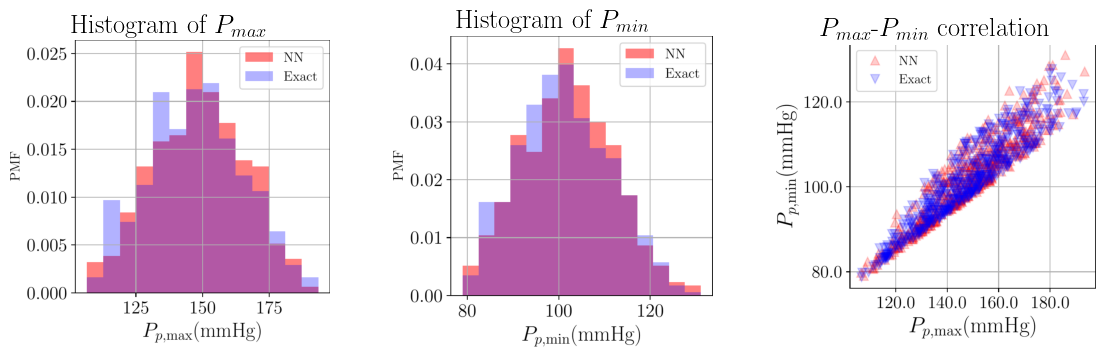

In [9]:
NF_Sample_size = 500 # How many samples needed

# sample z from N(0,1) and transform back to y
Y_hat_samples = NF_model.sampling(NF_Sample_size, NF_model, seed_control= 232542) # pick a random seed here

# Scaling back if needed
if Scaling == True:
    Y_hat_samples = scaler.scale_it_back(Y_hat_samples, muY, stdY)

# where to save the figures
path     = folder_name + '/figures/NF'

#Save histogram and scatter correlation plots
%matplotlib agg
hist_plot(path, 'Pmax-hist', Y_hat_samples[:,0], r'$P_{p,\max}(\textrm{mmHg})$', exact=Y_plot[:NF_Sample_size,0]) # hist of Pmax
hist_plot(path, 'Pmin-hist', Y_hat_samples[:,1], r'$P_{p,\min}(\textrm{mmHg})$', exact=Y_plot[:NF_Sample_size,1]) # hist of Pmin
scatter2D_plot(path, 'Pmax-Pmin-corr', Y_hat_samples, r'$P_{p,\max}(\textrm{mmHg})$', r'$P_{p,\min}(\textrm{mmHg})$', exact=Y_plot[:NF_Sample_size,:])
%matplotlib inline

# show figures
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
im1 = convert_from_path(path + '/Pmax-hist.pdf')
plt.imshow(im1[0])
plt.axis('off')
plt.title('Histogram of $P_{max}$', fontsize = fs-5)

plt.subplot(1, 3, 2)
im2 = convert_from_path(path + '/Pmin-hist.pdf')
plt.imshow(im2[0])
plt.axis('off')
plt.title('Histogram of $P_{min}$', fontsize = fs-5)

plt.subplot(1, 3, 3)
im3 = convert_from_path(path + '/Pmax-Pmin-corr.pdf')
plt.imshow(im3[0])
plt.axis('off')
plt.title('$P_{max}$-$P_{min}$ correlation', fontsize = fs-5)

### Training and testing step of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$

Waiting time: < 2 min

In [10]:
# training and testing step of the VAE and decoder
%matplotlib agg
Trainer.Decoder_train_test(folder_name, Decoder_model, lr_min[2], learning_rate[2], decay[2], nB[2], penalty, l2_decay = weight_decay[2])
%matplotlib inline



---------------Start to train the variational decoder-----------------
Total number of epoches for training variational decoder is:918
VAEDecoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, inversion loss: 8.022e-01 , inversion acc : 19.672221% , KL : 1.007e-01 , current lr: 1.000e-02
Testing: inversion loss: 6.687e-01 , inversion acc : 33.692766% , KL : 4.409e-02
Training: Epoch: 200, inversion loss: 5.907e-03 , inversion acc : 99.407109% , KL : 1.813e+00 , current lr: 3.670e-03
Testing: inversion loss: 1.152e-03 , inversion acc : 99.886059% , KL : 1.818e+00
Training: Epoch: 400, inversion loss: 5.523e-03 , inversion acc : 99.444234% , KL : 1.805e+00 , current lr: 1.347e-03
Testing: inversion loss: 9.133e-04 , inversion acc : 99.909915% , KL : 1.781e+00
Training: Epoch: 600, inversion loss: 5.520e-03 , inversion acc : 99.445023% , KL : 1.811e+00 , current lr: 4.941e-04
Testing: inversion loss: 7.546e-04 , inversion acc : 99.925507% , KL : 1.800e+00
Trai

### Verification of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$   

#### Task1: non-identifiability analysis

In this task, we fix a $\boldsymbol{y}^*$ sampled from the previously trained NF model $\mathscr{N}_f$ and sample $N$ latent variables $w$ from the latent space, which is the standard Gaussian distribution. This will give us $N$ values of $\tilde{\boldsymbol{y}}^* = [\boldsymbol{y}^*, w]^T$ that correpond to the same $\boldsymbol{y}^*$ and different values of $w \sim \mathcal{N}(0,1)$. 

Then, we apply the trained decoder $\mathscr{N}_d$ for model inversion, which predicts the system inputs $\widehat{\boldsymbol{v}}$ that should live in the non-identifiable subspace of $\boldsymbol{\mathcal{V}}$.

Note: the performance of inverse prediction may be affected by data imbalance, particularly when dealing with rare states of the system outputs. To determine whether a fixed $\boldsymbol{y}^*$ originates from the low-density region of the system output distribution, one can refer to the correlation figure above.

In [11]:
# sample one y^* from the trained NF 
y_fix  = NF_model.sampling(1, NF_model, seed_control= 831349) 

# how many latent variable w will be drawn from the latent space
W_size = 50 

# Decoding with trained N_d
X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, seed_control = 1243430 , Task = 'FixY', y_given = y_fix)

# Forward trained emulator here, results will be shown later
Encoder_model.eval()
with torch.no_grad():
    y_fix_predicted = Encoder_model(torch.from_numpy(X_samples)).detach().numpy()

# Scaling back if needed
if Scaling == True:
	X_samples   = scaler.scale_it_back(X_samples,muX,stdX) # scale back the inverse predictions of v
	y_fix       = scaler.scale_it_back(y_fix, muY, stdY) # scale back the fixed y, i.e. pmax pmin
# There is an indent level mis-match bug in Jupyter lab
if Scaling == True:
    y_fix_predicted  = scaler.scale_it_back(y_fix_predicted, muY, stdY) # scale back the emulator prediction

First, we plot the sample trajectory of the inverse prediction $\widehat{\boldsymbol{v}}$ as well as the correlations of its components, i.e. $R_p, R_d, C$.

(-0.5, 1192.5, 959.5, -0.5)

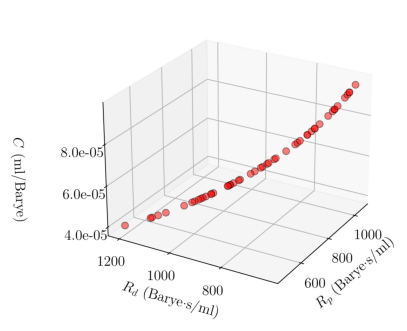

In [12]:
# scatter-plot of v_1,v_2 and v_3
path_inv     = folder_name + '/figures/Inversion'
elev         = 25   # view point argument 1
azim         = -150 # view point argument 2

# save scatter plot
%matplotlib agg
scatter3D_plot(path_inv, 'Fix-1-y', X_samples, [r'$R_p \ (\textrm{Barye·s/ml})$',\
											r'$R_d \ (\textrm{Barye·s/ml})$', \
											r'$C \ (\textrm{ml/Barye})$'], elev, azim, fmt=['%d','%d','%.1e'], away=[10,12,33]) # fmt is the label format, away is the distance btw label and axis
%matplotlib inline

# show scatter plot
plt.figure(figsize=(5, 5))
im_fix1y = convert_from_path(path_inv + '/Fix-1-y.pdf')
plt.imshow(im_fix1y[0])
plt.axis('off')

(-0.5, 849.5, 741.5, -0.5)

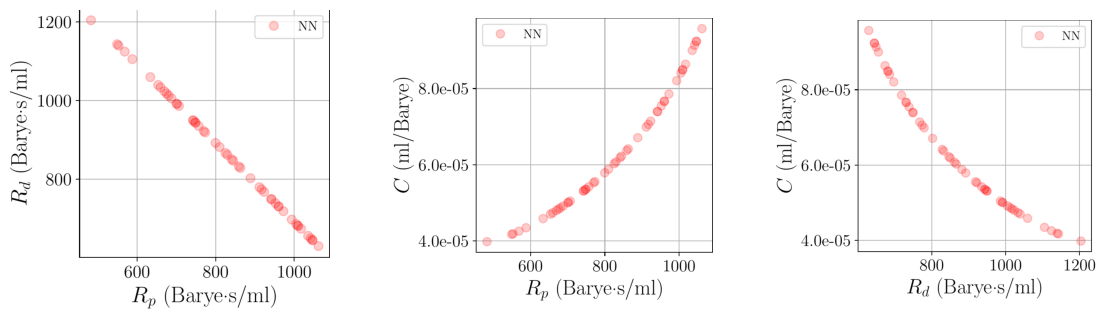

In [13]:
#Save scatter correlation plot
%matplotlib agg
scatter2D_plot(path_inv , 'Rp-Rd-corr', X_samples[:,[0,1]], \
			r'$R_p \ (\textrm{Barye·s/ml})$',r'$R_d \ (\textrm{Barye·s/ml})$', Mkr = 'ro', fmt=['%d','%d'])
scatter2D_plot(path_inv , 'Rp-C-corr',  X_samples[:,[0,2]], \
			r'$R_p \ (\textrm{Barye·s/ml})$',r'$C \ (\textrm{ml/Barye})$', Mkr = 'ro', fmt=['%d','%.1e'])
scatter2D_plot(path_inv , 'Rd-C-corr',  X_samples[:,[1,2]], \
			r'$R_d \ (\textrm{Barye·s/ml})$',r'$C \ (\textrm{ml/Barye})$', Mkr = 'ro', fmt=['%d','%.1e'])
%matplotlib inline

# show correlation figures
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
im_v1 = convert_from_path(path_inv + '/Rp-Rd-corr.pdf') # correlation of Rp and Rd
plt.imshow(im_v1[0])
plt.axis('off')

plt.subplot(1, 3, 2)
im_v2 = convert_from_path(path_inv + '/Rp-C-corr.pdf') # correlation of Rp and C
plt.imshow(im_v2[0])
plt.axis('off')


plt.subplot(1, 3, 3)
im_v3 = convert_from_path(path_inv + '/Rd-C-corr.pdf') # correlation of Rd and C
plt.imshow(im_v3[0])
plt.axis('off')

The learned parameter correlations match our previous discussion. Finally, we verify the current RCR system is indeed not identifiable with respect to these inverse predictions. To do so, we integrate in time with the resulting parameter combinations using the RK4 solver and keep track of the maximum and minimum pressure, i.e. $P_{p,\text{max}} , P_{p,\text{min}}$.

Besides, we can also verify the performance of the trained emulator $\mathscr{N}_e \ $ above, the emulator predictions $\widehat{P}_{p,\text{max}} , \widehat{P}_{p,\text{min}}$ will be superimposed to the following figure.

(-0.5, 2182.5, 1065.5, -0.5)

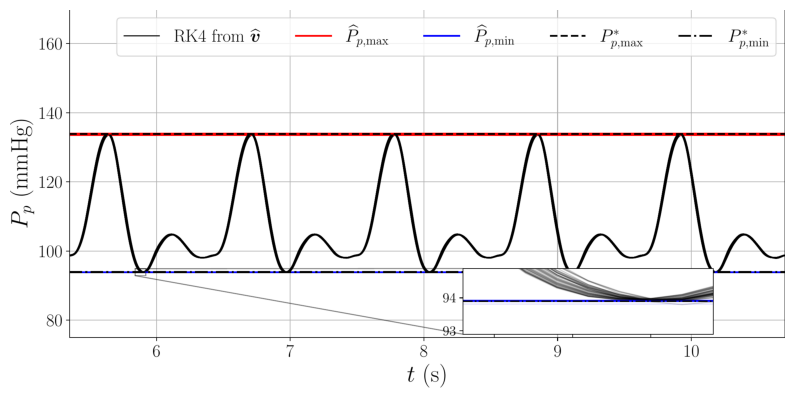

In [14]:
# where to save the picture
%matplotlib agg
fig_name = path_inv + '/RCR_verify.pdf'
RCR_dynamics_verification(X_samples, y_fix, y_fix_predicted, fig_name , y_lim=[75, 170])
%matplotlib inline

# show the plot
plt.figure(figsize=(10, 8))
im = convert_from_path(fig_name) # correlation of Rp and Rd
plt.imshow(im[0])
plt.axis('off')

From the figure above, we find the resulting periodic curves almost perfectly overlap with one another, all oscillating between the correct systolic and diastolic pressure. This proves our inverse predictions $\widehat{\boldsymbol{v}}$ indeed live in the non-identifiable subspace of $\boldsymbol{\mathcal{V}}$. In addition, the trained emulator $\mathscr{N}_e$ also provides accurate predictions of $\widehat{P}_{p,\text{max}}$ and  $\widehat{P}_{p,\text{min}}$.